In [120]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
from scipy.fftpack import dct, idct
from sklearn.linear_model import OrthogonalMatchingPursuit

warnings.filterwarnings("ignore")

def generate_sinusoid(dur=1, amp=1, freq=1, phase=0, Fs=100):
  """Generation of sinusoid

  Args:
      dur: Duration (in seconds) of sinusoid (Default value = 1)
      amp: Amplitude of sinusoid (Default value = 1)
      freq: Frequency (in Hertz) of sinusoid (Default value = 1)
      phase: Phase (relative to interval [0,1)) of sinusoid (Default value = 0)
      Fs: Sampling rate (in samples per second) (Default value = 100)

  Returns:
      x: Signal
      t: Time axis (in seconds)
  """
  num_samples = int(Fs * dur)
  t = np.arange(num_samples) / Fs
  x = amp * np.sin(2 * np.pi * freq * t - phase)
  return x, t

def sampling_equidistant(x_1, t_1, Fs_2, dur=None):
    """Equidistant sampling of interpolated signal

    Notebook: PCP_08_signal.ipynb

    Args:
        x_1: Signal to be interpolated and sampled
        t_1: Time axis (in seconds) of x_1
        Fs_2: Sampling rate used for equidistant sampling
        dur: Duration (in seconds) of sampled signal (Default value = None)

    Returns:
        x_2: Sampled signal
        t_2: time axis (in seconds) of sampled signal
    """
    if dur is None:
        dur = len(t_1) * t_1[1]
    N = int(Fs_2 * dur)
    t_2 = np.arange(N) / Fs_2
    x_2 = np.interp(t_2, t_1, x_1)
    return x_2, t_2
def reconstruction_sinc(x, t, t_sinc):
    """Reconstruction from sampled signal using sinc-functions

    Notebook: PCP_08_signal.ipynb

    Args:
        x: Sampled signal
        t: Equidistant discrete time axis (in seconds) of x
        t_sinc: Equidistant discrete time axis (in seconds) of signal to be reconstructed

    Returns:
        x_sinc: Reconstructed signal having time axis t_sinc
    """
    Fs = 1 / t[1]
    x_sinc = np.zeros(len(t_sinc))
    for n in range(0, len(t)):
        x_sinc += x[n] * np.sinc(Fs * t_sinc - n)
    return x_sinc

def plot_signal_reconstructed(t_1, x_1, t_2, x_2, t_sinc, x_sinc, figsize=(8, 2.2)):
    """Plotting three signals

    Notebook: PCP_08_signal.ipynb

    Args:
        t_1: Time axis of original signal
        x_1: Original signal
        t_2: Time axis for sampled signal
        x_2: Sampled signal
        t_sinc: Time axis for reconstructed signal
        x_sinc: Reconstructed signal
        figsize: Figure size (Default value = (8, 2.2))
    """
    plt.figure(figsize=figsize)
    plt.plot(t_1, x_1, 'k', linewidth=1, linestyle='dotted', label='Orignal signal')
    plt.scatter(t_2, x_2, marker='o', color='r', label='Samples')
    plt.plot(t_sinc, x_sinc, 'b', label='Reconstructed signal')
    plt.title(r'Sampling rate $F_\mathrm{s} = %.0f$' % (1/t_2[1]))
    plt.xlabel('Time (seconds)')
    plt.xlim([t_1[0], t_1[-1]])
    plt.legend(loc='upper right', framealpha=1)
    plt.tight_layout()
    plt.show()


def cosamp(phi, u, s, epsilon=1e-10, max_iter=1000):
    """
    Return an `s`-sparse approximation of the target signal
    Input:
        - phi, sampling matrix
        - u, noisy sample vector
        - s, sparsity
    """
    a = np.zeros(phi.shape[1])
    v = u
    it = 0 # count
    halt = False
    while not halt:
        it += 1
        print("Iteration {}\r".format(it), end="")
        
        y = np.dot(np.transpose(phi), v)
        omega = np.argsort(y)[-(2*s):] # large components
        omega = np.union1d(omega, a.nonzero()[0]) # use set instead?
        phiT = phi[:, omega]
        b = np.zeros(phi.shape[1])
        # Solve Least Square
        b[omega], _, _, _ = np.linalg.lstsq(phiT, u)
        
        # Get new estimate
        b[np.argsort(b)[:-s]] = 0
        a = b
        
        # Halt criterion
        v_old = v
        v = u - np.dot(phi, a)

        halt = (np.linalg.norm(v - v_old) < epsilon) or \
            np.linalg.norm(v) < epsilon or \
            it > max_iter
        
    return a


def plot_comparison_3x2(t, x, sampled_t, sampled_x, x_sinc, t_2, y, xrecon, 
                       nmse_sinc, nmse_cs, frequencies, original_fs):
    """
    Função para criar o plot comparativo 3x2 (domínio do tempo e frequência)
    
    Parâmetros:
    -----------
    t : array
        Eixo temporal do sinal original
    x : array
        Sinal original
    sampled_t : array
        Eixo temporal das amostras clássicas
    sampled_x : array
        Amostras clássicas
    x_sinc : array
        Sinal reconstruído pelo método clássico
    t_2 : array
        Eixo temporal das amostras CS
    y : array
        Amostras CS
    xrecon : array
        Sinal reconstruído por CS
    nmse_sinc : float
        NMSE da reconstrução clássica
    nmse_cs : float
        NMSE da reconstrução CS
    frequencies : list
        Lista das frequências dos tons
    original_fs : int
        Taxa de amostragem original
    """
    
    # Plot comparativo abrangente
    fig, axes = plt.subplots(3, 2, figsize=(15, 12))
    
    # Calcular domínio da frequência para todos os sinais
    freqs = np.fft.fftfreq(len(x), d=1/original_fs)
    freqs_pos = freqs[:len(freqs)//2]
    
    fft_original = np.fft.fft(x)
    fft_sinc = np.fft.fft(x_sinc)
    fft_cs = np.fft.fft(xrecon)
    
    # Linha 1: Sinal Original
    axes[0, 0].plot(t, x, 'k-', linewidth=1.5)
    axes[0, 0].set_title(f'Sinal Original ({len(frequencies)} tons: {", ".join(map(str, frequencies))} Hz)', 
                       fontweight='bold')
    axes[0, 0].set_xlabel('Tempo (s)')
    axes[0, 0].set_ylabel('Amplitude')
    axes[0, 0].grid(True, alpha=0.3)
    # axes[0, 0].set_xlim([0, 0.5])
    
    axes[0, 1].plot(freqs_pos, np.abs(fft_original[:len(freqs)//2]), 'k-', linewidth=1.5)
    for freq in frequencies:
        axes[0, 1].axvline(freq, color='red', linestyle='--', alpha=0.7, label=f'{freq} Hz')
    axes[0, 1].set_title('Espectro do Sinal Original', fontweight='bold')
    axes[0, 1].set_xlabel('Frequência (Hz)')
    axes[0, 1].set_ylabel('Magnitude')
    axes[0, 1].set_xlim([0, 100])
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].legend()
    
    # Linha 2: Reconstrução Clássica Sinc
    axes[1, 0].plot(t, x, 'k--', linewidth=1, alpha=0.5, label='Original')
    axes[1, 0].scatter(sampled_t, sampled_x, color='red', s=20, alpha=0.7, 
                      label=f'Amostras ({len(sampled_x)})')
    axes[1, 0].plot(t, x_sinc, 'b-', linewidth=1.5, label='Reconstrução Sinc')
    axes[1, 0].set_title(f'Reconstrução Clássica (NMSE: {nmse_sinc:.4f})', fontweight='bold')
    axes[1, 0].set_xlabel('Tempo (s)')
    axes[1, 0].set_ylabel('Amplitude')
    axes[1, 0].grid(True, alpha=0.3)
    # axes[1, 0].set_xlim([0, 0.5])
    axes[1, 0].legend()
    
    axes[1, 1].plot(freqs_pos, np.abs(fft_sinc[:len(freqs)//2]), 'b-', linewidth=1.5, 
                   label='Reconstrução Sinc')
    axes[1, 1].plot(freqs_pos, np.abs(fft_original[:len(freqs)//2]), 'k--', linewidth=1, 
                   alpha=0.5, label='Original')
    for freq in frequencies:
        axes[1, 1].axvline(freq, color='red', linestyle='--', alpha=0.7)
    axes[1, 1].set_title('Espectro da Reconstrução Clássica', fontweight='bold')
    axes[1, 1].set_xlabel('Frequência (Hz)')
    axes[1, 1].set_ylabel('Magnitude')
    axes[1, 1].set_xlim([0, 100])
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].legend()
    
    # Linha 3: Reconstrução por Amostragem Compressiva
    axes[2, 0].plot(t, x, 'k--', linewidth=1, alpha=0.5, label='Original')
    axes[2, 0].scatter(t_2, y, color='red', s=20, alpha=0.7, 
                      label=f'Amostras aleatórias ({len(y)})')
    axes[2, 0].plot(t, xrecon, 'g-', linewidth=1.5, label='Reconstrução CS')
    axes[2, 0].set_title(f'Reconstrução por Sensoriamento Comprimido (NMSE: {nmse_cs:.4f})', 
                       fontweight='bold')
    axes[2, 0].set_xlabel('Tempo (s)')
    axes[2, 0].set_ylabel('Amplitude')
    axes[2, 0].grid(True, alpha=0.3)
    # axes[2, 0].set_xlim([0, 0.5])
    axes[2, 0].legend()
    
    axes[2, 1].plot(freqs_pos, np.abs(fft_cs[:len(freqs)//2]), 'g-', linewidth=1.5, 
                   label='Reconstrução CS')
    axes[2, 1].plot(freqs_pos, np.abs(fft_original[:len(freqs)//2]), 'k--', linewidth=1, 
                   alpha=0.5, label='Original')
    for freq in frequencies:
        axes[2, 1].axvline(freq, color='red', linestyle='--', alpha=0.7)
    axes[2, 1].set_title('Espectro da Reconstrução CS', fontweight='bold')
    axes[2, 1].set_xlabel('Frequência (Hz)')
    axes[2, 1].set_ylabel('Magnitude')
    axes[2, 1].set_xlim([0, 100])
    axes[2, 1].grid(True, alpha=0.3)
    axes[2, 1].legend()
    
    plt.tight_layout()
    plt.suptitle('Comparação de Reconstrução de Sinais: Clássica vs Sensoriamento Comprimido', 
                 fontsize=16, fontweight='bold', y=1.02)
    plt.show()

def calculate_nmse(original, reconstructed):
    """Calculate Normalized Mean Square Error"""
    mse = np.mean((original - reconstructed)**2)
    signal_power = np.mean(original**2)
    nmse = mse / signal_power
    return nmse

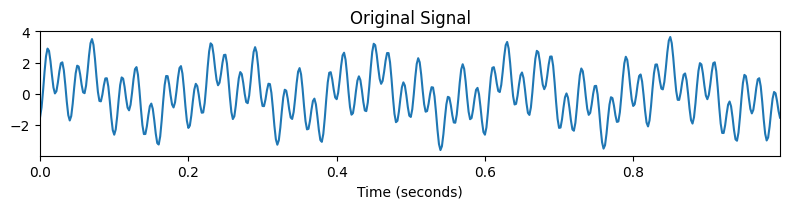

In [104]:
original_fs = 500
dur = 1

# Tone 1
a1 = 1
f1 = 5
p1 = 0
x_1, t_1 = generate_sinusoid(dur=dur, amp=a1, freq=f1, phase=p1, Fs=original_fs)

# Tone 2
a2 = 1.2
f2 = 18
p2 = 0
x_2, _ = generate_sinusoid(dur=dur, amp=a2, freq=f2, phase=p2, Fs=original_fs)

# Tone 3
a3 = 1.5
f3 = 50
p3 = np.deg2rad(90)
x_3, _ = generate_sinusoid(dur=dur, amp=a3, freq=f3, phase=p3, Fs=original_fs)

freqs = [f1, f2, f3]

t = t_1
x = x_1 + x_2 + x_3

N = len(x)
M = 60

plt.figure(figsize=(8, 2.2))
plt.plot(t, x)
plt.xlim([t[0], t[-1]])
plt.title('Original Signal')
plt.xlabel('Time (seconds)')
plt.tight_layout()
plt.show()

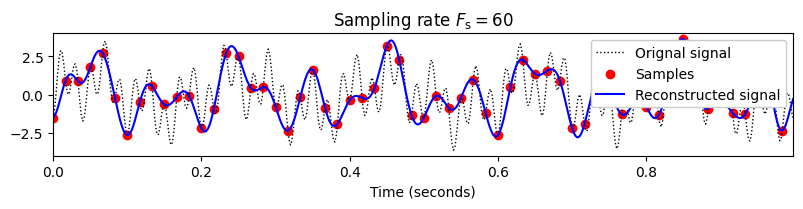

In [105]:
Fs = M
sampled_x, sampled_t = sampling_equidistant(x, t, Fs)
t_sinc = t
x_sinc = reconstruction_sinc(sampled_x, sampled_t, t_sinc)
plot_signal_reconstructed(t, x, sampled_t, sampled_x, t_sinc, x_sinc)

nmse_sinc = calculate_nmse(x, x_sinc)

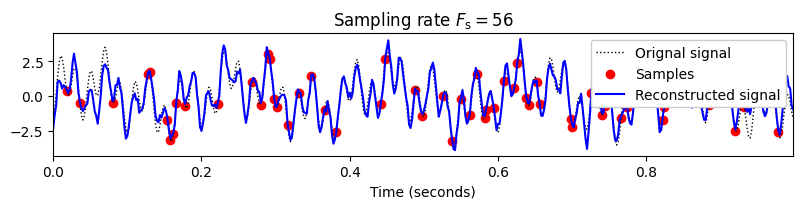

In [116]:
from sklearn.linear_model import OrthogonalMatchingPursuit

# Sensing matrix
random_state = 80
rng = np.random.default_rng(random_state)
perm = np.floor(rng.random(M) * N).astype(int)
y = x[perm]

t_2 = t[perm]

Psi = dct(np.identity(N))
Theta = Psi[perm,:]
omp = OrthogonalMatchingPursuit(tol=1e-12)
omp.fit(Theta, y)
s_value = omp.coef_

xrecon = idct(s_value)

plot_signal_reconstructed(t, x, t_2, y, t, xrecon)
nmse_cs = calculate_nmse(x, xrecon)

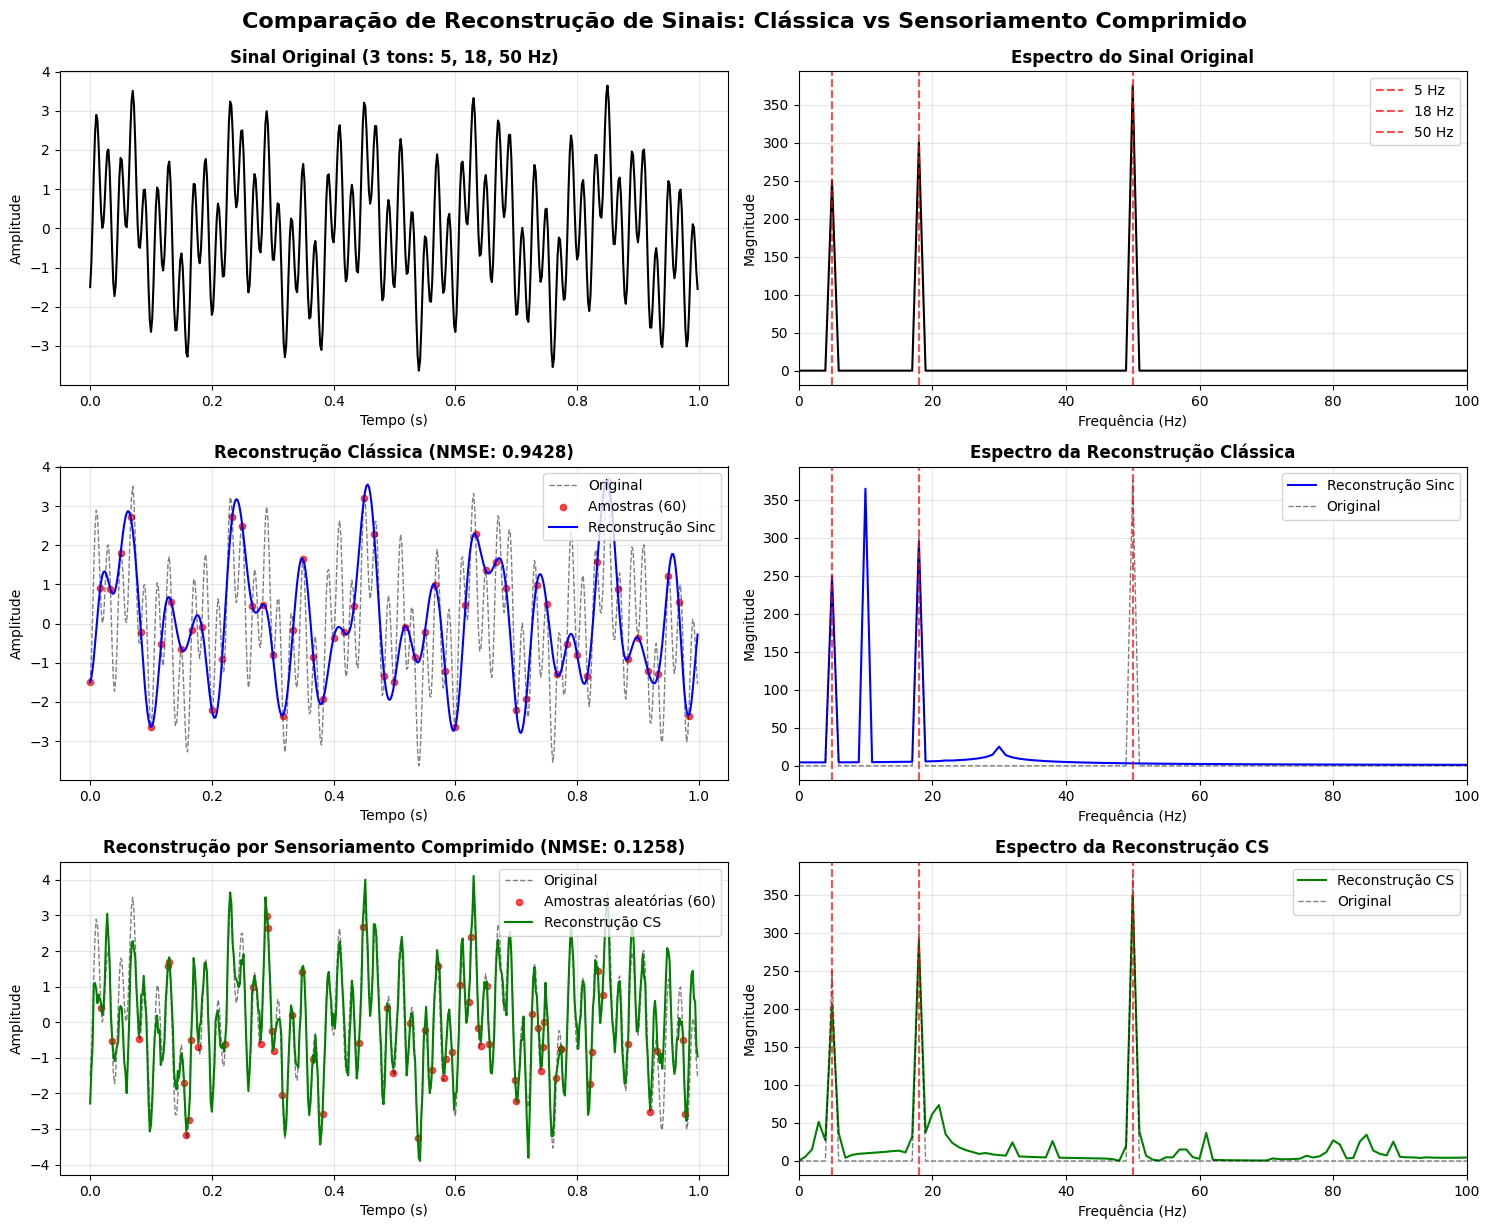

In [121]:
plot_comparison_3x2(t, x, sampled_t, sampled_x, x_sinc, t_2, y, xrecon, 
                   nmse_sinc, nmse_cs, freqs, original_fs)